In [1]:
import matplotlib.pyplot as plt
import numpy as np

import yt

yt : [INFO     ] 2023-02-06 12:38:32,767 Parameters: current_time              = 0.0
yt : [INFO     ] 2023-02-06 12:38:32,769 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2023-02-06 12:38:32,770 Parameters: domain_left_edge          = [-1. -1. -1.]
yt : [INFO     ] 2023-02-06 12:38:32,772 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [WARNING  ] 2023-02-06 12:38:33,510 Field ('gas', 'enstrophy') was added without specifying units or dimensions, auto setting units to g/cm**3
yt : [WARNING  ] 2023-02-06 12:38:33,517 Field ('gas', 'kinetic_energy') was added without specifying units or dimensions, auto setting units to dyn/cm**2
yt : [INFO     ] 2023-02-06 12:38:33,577 Parameters: current_time              = 4.91783609240359e-05
yt : [INFO     ] 2023-02-06 12:38:33,578 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2023-02-06 12:38:33,580 Parameters: domain_left_edge          = [-1. -1. -1.]
yt : [INFO     ] 2023-02-06 12:38:33,582 Par

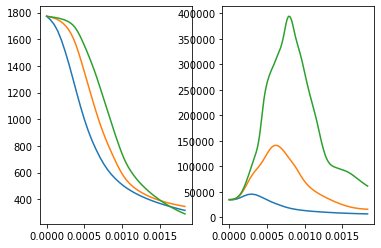

In [2]:
def kinetic_energy(field, data):
  return 0.5 * data["gas", "density"] * (data["gas", "velocity_x"]**2 + data["gas", "velocity_y"]**2 + data["gas", "velocity_z"]**2)

def enstrophy(field, data):
  return 0.5 * data["gas", "density"] * data["boxlib", "magvort"]**2

datasets = ["../../Exec/TGV/muscl/32^3/plt*", "../../Exec/TGV/muscl/64^3/plt*", "../../Exec/TGV/muscl/128^3/plt*"]
data = []

for dataset in datasets:
  ts = yt.load(dataset)

  storage = {}

  for store, ds in ts.piter(storage=storage):
    ds.add_field(("gas", "kinetic_energy"), function=kinetic_energy, sampling_type="cell")
    ds.add_field(("gas", "enstrophy"), function=enstrophy, sampling_type="cell")

    cube = ds.covering_grid(0, left_edge=ds.domain_left_edge, dims=ds.domain_dimensions, fields=[("gas", "kinetic_energy"), ("gas", "enstrophy")])
    ke = cube[("gas", "kinetic_energy")].mean()
    en = cube[("gas", "enstrophy")].mean()
    
    store.result = (ds.current_time, ke, en)

  arr = np.array(list(storage.values()))
  plt.subplot(1,2,1)
  plt.plot(arr[:,0], arr[:,1])
  plt.subplot(1,2,2)
  plt.plot(arr[:,0], arr[:,2])

  data.append(arr)

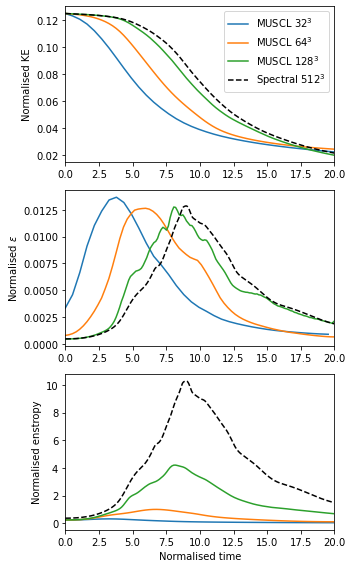

In [3]:
ref_data = np.loadtxt("../../Exec/TGV/refdata/spectral_Re1600_512.gdiag", comments="#", delimiter=" ")

v0 = 3471.902257 
rho0 = 0.001176528632
tc = 0.0018336339443081453/20

# labels = [r"WENOZ5 $32^3$", r"WENOZ5 $64^3$", r"WENOZ5 $128^3$"]
labels = [r"MUSCL $32^3$", r"MUSCL $64^3$", r"MUSCL $128^3$"]

fig, ax = plt.subplots(3, figsize=(5,8))
for i in range(len(data)):
  ax[0].plot(data[i][:,0]/tc, data[i][:,1]/rho0/v0/v0, label=labels[i])
ax[0].plot(ref_data[:,0], ref_data[:,1], 'k--', label=r"Spectral $512^3$")
# ax[0].set_xlabel("Normalised time")
ax[0].set_ylabel("Normalised KE")
ax[0].set_xlim([0, 20])
ax[0].legend(loc="upper right")

for i in range(len(data)):
  ax[1].plot(data[i][:-1,0]/tc, -(data[i][1:,1]-data[i][:-1,1])/(data[i][1:,0]-data[i][:-1,0])*tc/rho0/v0/v0, label=labels[i])
ax[1].plot(ref_data[:,0], ref_data[:,2], 'k--', label="Spectral 512^3")
# ax[1].set_xlabel("Normalised time")
ax[1].set_ylabel(r"Normalised $\epsilon$")
ax[1].set_xlim([0, 20])

for i in range(len(data)):
  ax[2].plot(data[i][:,0]/tc, data[i][:,2]*tc**2/rho0, label=labels[i])
ax[2].plot(ref_data[:,0], ref_data[:,3], 'k--', label="Spectral 512^3")
ax[2].set_xlabel("Normalised time")
ax[2].set_ylabel("Normalised enstropy")
ax[2].set_xlim([0, 20])

# lines_labels = [ax[0].get_legend_handles_labels()]
# lines, labelss = [sum(lol, []) for lol in zip(*lines_labels)]
# fig.legend(lines, labelss, loc='upper center', ncol=2)

fig.tight_layout()

plt.savefig("TVG")

In [3]:
np.savez("muscl_tvg", data=data)

/usr/lib/python3/dist-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


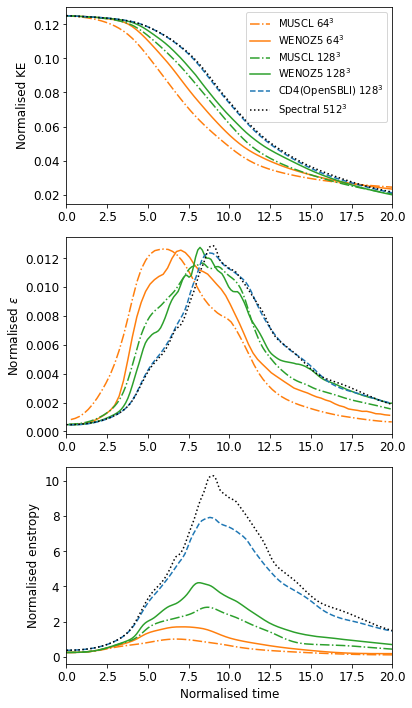

In [11]:
import matplotlib.pyplot as plt
import numpy as np

dat = np.load("wenoz5_tvg.npz", allow_pickle=True)
weno_dat = dat["data"]

dat = np.load("muscl_tvg.npz", allow_pickle=True)
muscl_dat = dat["data"]

ref_data = np.loadtxt("../../Exec/TGV/refdata/spectral_Re1600_512.gdiag", comments="#", delimiter=" ")
ref_data2 = np.loadtxt("../../Exec/TGV/refdata/opensbli_128.dat", comments="#", delimiter=" ")
v0 = 3471.902257 
rho0 = 0.001176528632
tc = 0.0018336339443081453/20

labels = [#r"MUSCL $32^3$", r"WENOZ5 $32^3$", 
r"MUSCL $64^3$", r"WENOZ5 $64^3$", r"MUSCL $128^3$", r"WENOZ5 $128^3$", 
r"CD4(OpenSBLI) $128^3$", r"Spectral $512^3$"]

plt.rc('font', size=12)

fig, ax = plt.subplots(3, figsize=(6,10))
for i in range(1,3):
  ax[0].plot(muscl_dat[i][:,0]/tc, muscl_dat[i][:,1]/rho0/v0/v0, '-.', color="C"+str(i))
  ax[0].plot(weno_dat[i][:,0]/tc, weno_dat[i][:,1]/rho0/v0/v0, '-', color="C"+str(i))
ax[0].plot(ref_data2[:,0], ref_data2[:,1], '--')
ax[0].plot(ref_data[:,0], ref_data[:,1], 'k:')
ax[0].set_ylabel("Normalised KE")
ax[0].set_xlim([0, 20])
ax[0].legend(labels, loc="upper right", ncol=1, labelspacing=0.3, prop={'size': 10})

for i in range(1,3):
  ax[1].plot(weno_dat[i][1:-1,0]/tc, -(weno_dat[i][2:,1]-weno_dat[i][:-2,1])/(weno_dat[i][2:,0]-weno_dat[i][:-2,0])*tc/rho0/v0/v0, '-', color="C"+str(i))
  ax[1].plot(muscl_dat[i][1:-1,0]/tc, -(muscl_dat[i][2:,1]-muscl_dat[i][:-2,1])/(muscl_dat[i][2:,0]-muscl_dat[i][:-2,0])*tc/rho0/v0/v0, '-.', color="C"+str(i))
ax[1].plot(ref_data2[1:-1,0], -(ref_data2[2:,1]-ref_data2[:-2,1])/(ref_data2[2:,0]-ref_data2[:-2,0]), '--')
ax[1].plot(ref_data[:,0], ref_data[:,2], 'k:', label="Spectral 512^3")
ax[1].set_ylabel(r"Normalised $\epsilon$")
ax[1].set_xlim([0, 20])

for i in range(1,3):
  ax[2].plot(weno_dat[i][:,0]/tc, weno_dat[i][:,2]*tc**2/rho0, '-', color="C"+str(i))
  ax[2].plot(muscl_dat[i][:,0]/tc, muscl_dat[i][:,2]*tc**2/rho0, '-.', color="C"+str(i))
ax[2].plot(ref_data2[:,0], ref_data2[:,2], '--', label="OpenSBLI 128^3")
ax[2].plot(ref_data[:,0], ref_data[:,3], 'k:', label="Spectral 512^3")
ax[2].set_xlabel("Normalised time")
ax[2].set_ylabel("Normalised enstropy")
ax[2].set_xlim([0, 20])

fig.tight_layout()

plt.savefig("TGV")